In [1]:
from re import I
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import mysql.connector
import pymysql
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
import pickle


In [2]:
df= pd.read_csv('data/AEP_hourly.csv')

In [6]:
df.describe()

,AEP_MW
count,121273.000000
mean,15499.513717
std,2591.399065
min,9581.000000
25%,13630.000000
50%,15310.000000
75%,17200.000000
max,25695.000000


In [5]:
df.tail()

,Datetime,AEP_MW
121268,2018-01-01 20:00:00,21089.0
121269,2018-01-01 21:00:00,20999.0
121270,2018-01-01 22:00:00,20820.0
121271,2018-01-01 23:00:00,20415.0
121272,2018-01-02 00:00:00,19993.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121273 entries, 0 to 121272
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  121273 non-null  object 
 1   AEP_MW    121273 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.9+ MB


In [5]:
df.isnull().sum()

Datetime    0
AEP_MW      0
dtype: int64

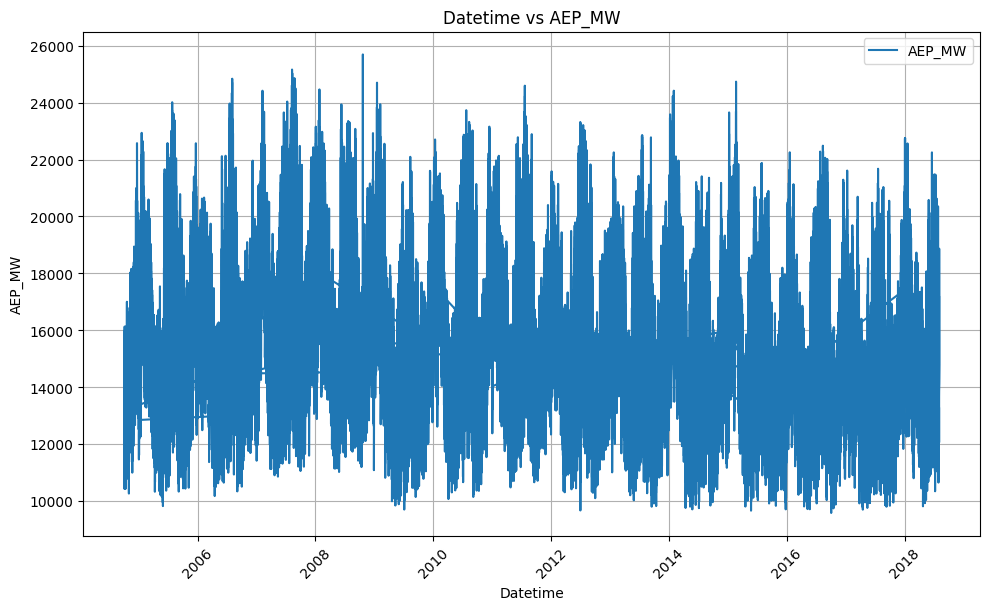

In [6]:
df['Datetime'] = pd.to_datetime(df['Datetime'])

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(df['Datetime'], df['AEP_MW'], label='AEP_MW')
plt.xlabel('Datetime')
plt.ylabel('AEP_MW')
plt.title('Datetime vs AEP_MW')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

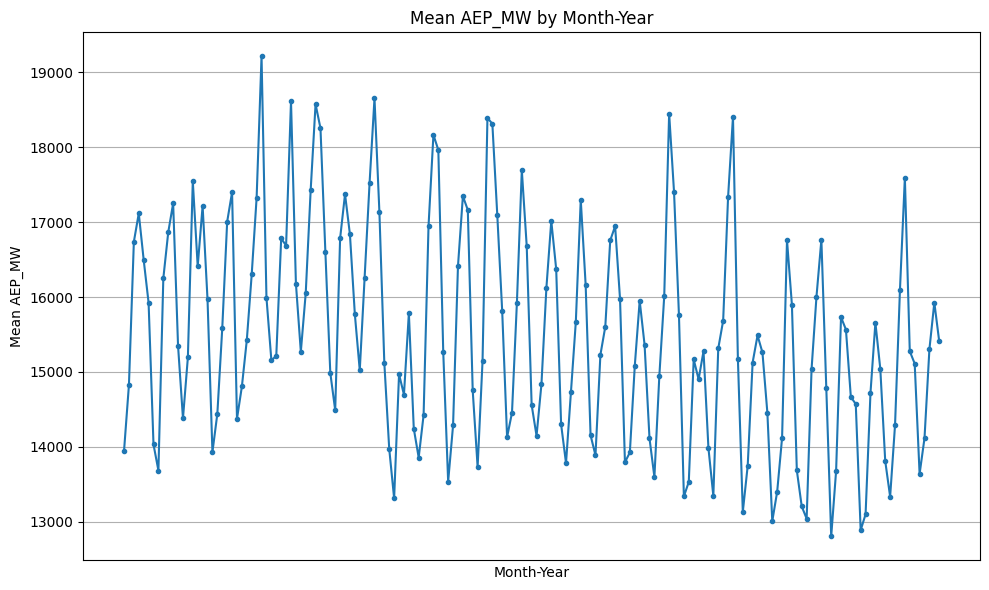

In [7]:
df['Year'] = df['Datetime'].dt.year
df['Month'] = df['Datetime'].dt.month

# Group by year and month, and calculate the mean 'AEP_MW' for each month
monthly_avg_aep = df.groupby(['Year', 'Month'])['AEP_MW'].mean().reset_index()

# Plot Month-Year against Mean AEP_MW
plt.figure(figsize=(10, 6))
plt.plot(monthly_avg_aep['Year'].astype(str) + '-' + monthly_avg_aep['Month'].astype(str), 
         monthly_avg_aep['AEP_MW'], marker='.')
plt.xlabel('Month-Year')
plt.ylabel('Mean AEP_MW')
plt.title('Mean AEP_MW by Month-Year')
plt.xticks([])
plt.grid(True)
plt.tight_layout()
plt.show()

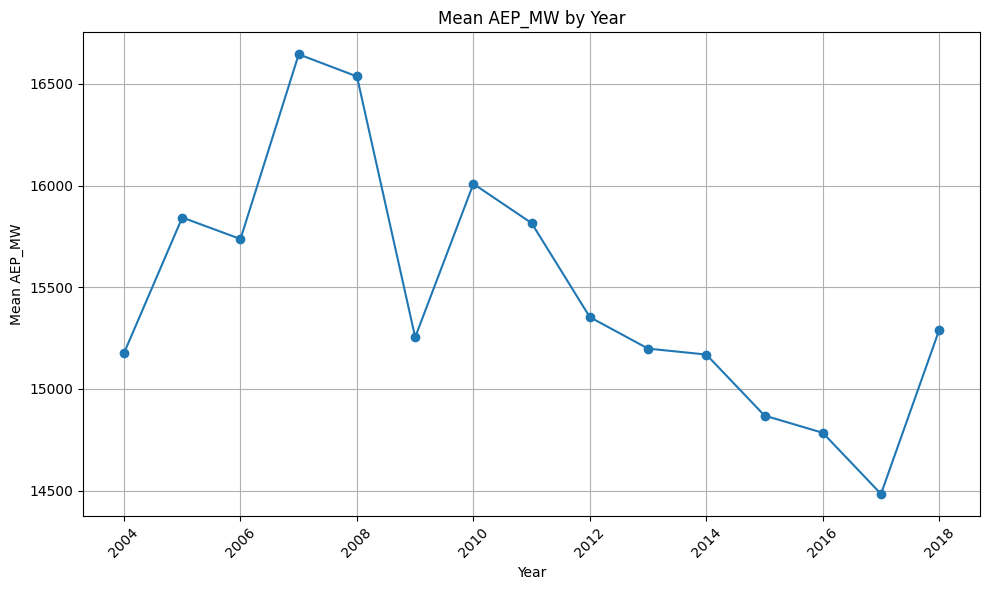

In [8]:
yearly_avg_aep = df.groupby('Year')['AEP_MW'].mean()

# Plot Year against Mean AEP_MW
plt.figure(figsize=(10, 6))
plt.plot(yearly_avg_aep.index, yearly_avg_aep.values, marker='o')
plt.xlabel('Year')
plt.ylabel('Mean AEP_MW')
plt.title('Mean AEP_MW by Year')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
df.drop(['Month','Year'],inplace=True,axis=1)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121273 entries, 0 to 121272
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   Datetime  121273 non-null  datetime64[ns]
 1   AEP_MW    121273 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.9 MB


#### Insertion in db

In [16]:
# # Define connection parameters
# hostname = "localhost"
# port = 3306
# username = "root"
# password = "umar@123"
# database = "TSP1"

# # Establish a connection to the MySQL database
# connection = pymysql.connect(host=hostname, port=port, user=username, passwd=password, db=database)

# # Create a cursor object to execute SQL queries
# cursor = connection.cursor()

# # Example DataFrame (replace this with your actual DataFrame)


# # Define the table name in your database
# table_name = "data"

# # Create the INSERT INTO query
# insert_query = f"INSERT INTO {table_name} (`DateTime`, Consumption) VALUES (%s, %s)"

# # Iterate over DataFrame rows and insert data into the table
# for _, row in df.iterrows():
#     values = tuple(row.values)
#     cursor.execute(insert_query, values)

# # Commit changes to the database
# connection.commit()

# # Close the cursor and connection
# cursor.close()
# connection.close()

# print(f"Data successfully inserted into MySQL table '{table_name}' in database '{database}'.")


Data successfully inserted into MySQL table 'data' in database 'TSP1'.


In [9]:
# Perform Augmented Dickey-Fuller test on 'AEP_MW'
adf_result = adfuller(df['AEP_MW'])

# Extract and print ADF test results
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value}')

# Interpret ADF test results
if adf_result[1] <= 0.05:
    print("\nThe time series is likely stationary (reject null hypothesis)")
else:
    print("\nThe time series is likely non-stationary (fail to reject null hypothesis)")

ADF Statistic: -16.446812104686718
p-value: 2.3990113240021998e-29
Critical Values:
   1%: -3.430403955318047
   5%: -2.8615638474512295
   10%: -2.566782693155802

The time series is likely stationary (reject null hypothesis)


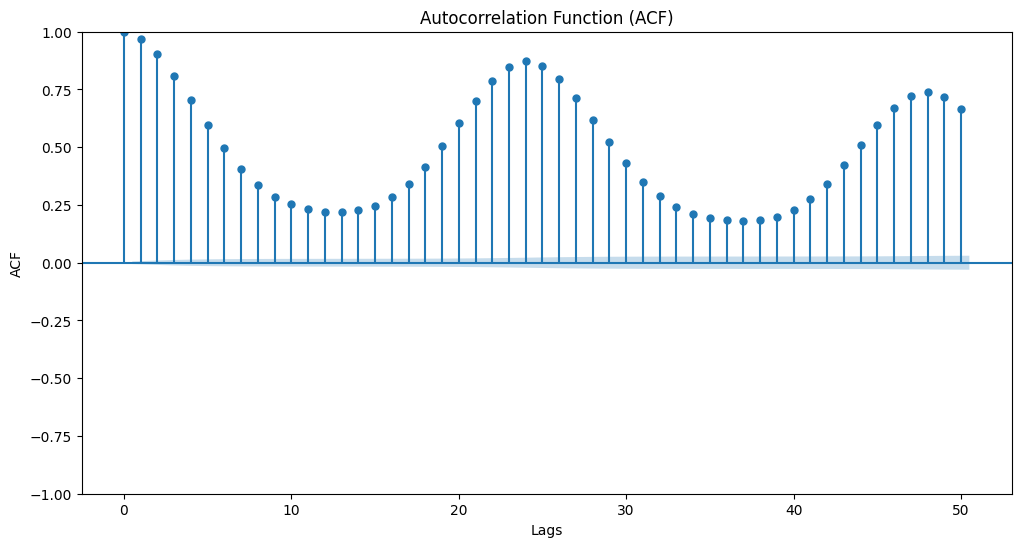

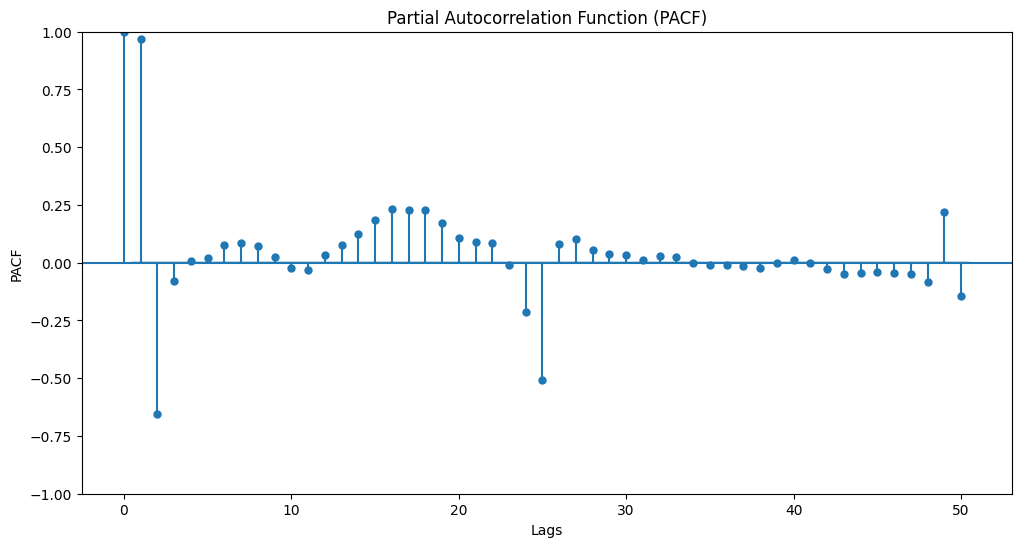

In [18]:
plt.figure(figsize=(12, 6))
plot_acf(df['AEP_MW'], lags=50, ax=plt.gca())
plt.xlabel('Lags')
plt.ylabel('ACF')
plt.title('Autocorrelation Function (ACF)')
plt.show()

# Plot PACF
plt.figure(figsize=(12, 6))
plot_pacf(df['AEP_MW'], lags=50, ax=plt.gca())
plt.xlabel('Lags')
plt.ylabel('PACF')
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

In [52]:
df.tail()

,Datetime,AEP_MW
121268,2018-01-01 20:00:00,21089.0
121269,2018-01-01 21:00:00,20999.0
121270,2018-01-01 22:00:00,20820.0
121271,2018-01-01 23:00:00,20415.0
121272,2018-01-02 00:00:00,19993.0


#### ARIMA

In [8]:
order = (4, 0, 2)  # Use appropriate values based on analysis
model = ARIMA(df['AEP_MW'], order=order)
fitted_model = model.fit()


/home/umar/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/umar/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/umar/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/umar/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/umar/.local/

In [9]:
forecast_steps = 10
forecast = fitted_model.forecast(steps=forecast_steps)

/home/umar/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/umar/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [10]:
forecast

121273    19444.608964
121274    18884.205426
121275    18300.504618
121276    17768.829648
121277    17261.201340
121278    16832.890419
121279    16445.574364
121280    16141.296760
121281    15877.021832
121282    15686.777938
Name: predicted_mean, dtype: float64

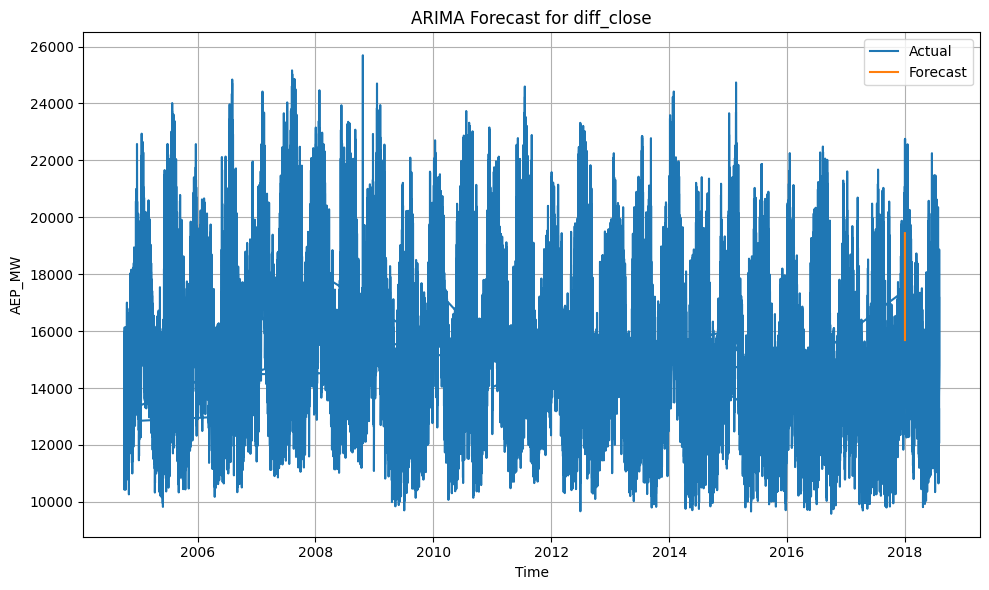

In [71]:
forecast_dates = pd.date_range(start=df['Datetime'].iloc[-1], periods=forecast_steps+1, freq='H')[1:]

# Plot actual vs. predicted values with correct time index for forecast
plt.figure(figsize=(10, 6))
plt.plot(df['Datetime'], df['AEP_MW'], label='Actual')
plt.plot(forecast_dates, forecast, label='Forecast')
plt.xlabel('Time')
plt.ylabel('AEP_MW')
plt.title('ARIMA Forecast for diff_close')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#### Saving ARIMA

In [11]:
with open('arima_model.pkl', 'wb') as f:
    pickle.dump(fitted_model, f)

#### SARIMA

In [73]:
order = (2, 0, 1)  # Example non-seasonal order (p, d, q)
seasonal_order = (2, 0, 1, 12)  # Example seasonal order (P, D, Q, s)

# Create and fit SARIMA model
sarima_model = SARIMAX(df['AEP_MW'], order=order, seasonal_order=seasonal_order)
fitted_sarima_model = sarima_model.fit()

# Forecast
forecast_steps = 10  # Example: forecast next 12 steps
forecast = fitted_sarima_model.forecast(steps=forecast_steps)

forecast


RUNNING THE L-BFGS-B CODE

           * * *


 This problem is unconstrained.



Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.52466D+00    |proj g|=  2.78190D-01

At iterate    5    f=  7.41954D+00    |proj g|=  1.65592D-02

At iterate   10    f=  7.41539D+00    |proj g|=  1.10656D-03

At iterate   15    f=  7.41524D+00    |proj g|=  9.45483D-04

At iterate   20    f=  7.41430D+00    |proj g|=  1.89376D-02

At iterate   25    f=  7.38425D+00    |proj g|=  1.32124D-02

At iterate   30    f=  7.38333D+00    |proj g|=  7.78053D-03

At iterate   35    f=  7.34486D+00    |proj g|=  1.89618D-02

At iterate   40    f=  7.32438D+00    |proj g|=  7.78606D-03

At iterate   45    f=  7.32406D+00    |proj g|=  3.75143D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized C

: 

In [ ]:
forecast

****************************************************

# Calculating MAPEs

# ARIMA

In [10]:
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import pickle

# Load the data
df = pd.read_csv('data/AEP_hourly.csv')
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.set_index('Datetime', inplace=True)

# Apply log transformation
df['AEP_MW_log'] = np.log(df['AEP_MW'])

# Define ARIMA order
order = (2, 0, 1)

# Train ARIMA model
model = ARIMA(df['AEP_MW_log'], order=order)
fitted_model = model.fit()

# Save the model
with open('arima_model.pkl', 'wb') as f:
    pickle.dump(fitted_model, f)

# Get predictions
predictions_log = fitted_model.predict(typ='levels')

# Invert log transformation
predictions = np.exp(predictions_log)

# Calculate MSE and MAPE
mape = np.mean(np.abs((df['AEP_MW'] - predictions) / df['AEP_MW'])) * 100

print(f"MAPE: {mape}%")


/home/umar/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/umar/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/umar/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/umar/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/umar/.local/

MAPE: 2.0466315231673327%


# ETS

In [9]:
import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
import numpy as np

# Load the data
df = pd.read_csv('data/AEP_hourly.csv')
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.set_index('Datetime', inplace=True)

# Apply log transformation to 'AEP_MW' column
df['AEP_MW_log'] = np.log(df['AEP_MW'])

# Split data into training and testing sets
train_size = int(len(df) * 0.8)  # 80% train, 20% test
train_data, test_data = df.iloc[:train_size], df.iloc[train_size:]

# Train the ETS model on the training data
model = ExponentialSmoothing(train_data['AEP_MW_log'], trend='add', seasonal='add', seasonal_periods=12)
fitted_model = model.fit()

# Generate forecasts on the test data
forecast_next_steps = len(test_data)  # Forecast for the entire test set
forecast_next_values_log = fitted_model.forecast(steps=forecast_next_steps)

# Invert log transformation for forecasted values
forecast_next_values = np.exp(forecast_next_values_log)

# Calculate Mean Squared Error (MSE)

# Calculate Mean Absolute Percentage Error (MAPE)
mape = 100 * np.mean(np.abs((test_data['AEP_MW'].values - forecast_next_values) / test_data['AEP_MW'].values))

print(f"MAPE: {mape}%")


/home/umar/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/umar/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/umar/.local/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/home/umar/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/umar/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supporte

MAPE: 29.604636386377177%


# SARIMA

In [8]:
import pandas as pd
import pickle
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np

# Load the data
df = pd.read_csv('data/AEP_hourly.csv')
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.set_index('Datetime', inplace=True)

# Split data into training and testing sets
train_size = int(len(df) * 0.8)  # 80% train, 20% test
train_data, test_data = df.iloc[:train_size], df.iloc[train_size:]

# Load the SARIMA model from the pickle file
with open('sarima_model.pkl', 'rb') as f:
    sarima_model = pickle.load(f)

# Generate forecasts with the loaded SARIMA model
forecast_next_steps = len(test_data)  # Forecast for the entire test set
forecast_next_values = sarima_model.forecast(steps=forecast_next_steps)

# Calculate Mean Absolute Percentage Error (MAPE)
mape = mean_absolute_percentage_error(test_data['AEP_MW'], forecast_next_values)

print(f"MAPE: {mape * 100}%")


MAPE: 28.70197848400149%


# Prophet


In [7]:
import pandas as pd
import pickle
from prophet import Prophet
import numpy as np

# Load the data
df = pd.read_csv('data/AEP_hourly.csv')
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.rename(columns={'Datetime': 'ds', 'AEP_MW': 'y'}, inplace=True)

# Split data into training and testing sets
train_size = int(len(df) * 0.8)  # 80% train, 20% test
train_data, test_data = df.iloc[:train_size], df.iloc[train_size:]

# Load the saved Prophet model from the pickle file
with open('prophet_model.pkl', 'rb') as f:
    model, forecast = pickle.load(f)

# Use the loaded model to forecast values for the test data period
forecast_test = model.predict(test_data)

# Extract forecasted values and actual values
forecast_values = forecast_test['yhat'].values
actual_values = test_data['y'].values

# Calculate Mean Absolute Percentage Error (MAPE)
mape = 100 * np.mean(np.abs((actual_values - forecast_values) / actual_values))

print(f"MAPE: {mape}%")


MAPE: 14.35845521823682%


# LSTM

In [21]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


# # Load your dataset and preprocess it
df = pd.read_csv('data/AEP_hourly.csv')

# # Convert 'Datetime' column to datetime type
df['Datetime'] = pd.to_datetime(df['Datetime'])

# Extract features from datetime
df['Hour'] = df['Datetime'].dt.hour
df['Day'] = df['Datetime'].dt.day
df['Month'] = df['Datetime'].dt.month
df['Year'] = df['Datetime'].dt.year
# Separate features (X) and target variable (y)
X = df[['Hour', 'Day', 'Month', 'Year']].values
y = df['AEP_MW'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()


# # Define hyperparameters
input_size = X_train.shape[1]
hidden_size = 64

# Loading and testing 


class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1, num_layers=2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Take the last time step's output
        return out

model_path = '/content/drive/MyDrive/lstm_model.pth'

# Load the model
model = LSTMModel(input_size, hidden_size)
model.load_state_dict(torch.load('lstm_model.pth'))

# Get the last known data
last_known_data = df.iloc[-1]
last_known_hour = last_known_data['Hour']
last_known_day = last_known_data['Day']
last_known_month = last_known_data['Month']
last_known_year = last_known_data['Year']

# Prepare next 12 timestamps
next_12_timestamps = []
for i in range(1, 13):  # Next 12 timestamps
    next_timestamp = pd.Timestamp(year=last_known_year, month=last_known_month, 
                                  day=last_known_day, hour=last_known_hour) + pd.Timedelta(hours=i)
    next_12_timestamps.append(next_timestamp)

# Extract features for the next 12 timestamps
next_12_data = pd.DataFrame({'Timestamp': next_12_timestamps})
next_12_data['Hour'] = next_12_data['Timestamp'].dt.hour
next_12_data['Day'] = next_12_data['Timestamp'].dt.day
next_12_data['Month'] = next_12_data['Timestamp'].dt.month
next_12_data['Year'] = next_12_data['Timestamp'].dt.year

# Assuming you have X_next_data with the features Hour, Day, Month, Year for the next timestamps
X_next_data = next_12_data[['Hour', 'Day', 'Month', 'Year']].values
X_next_scaled = scaler_X.transform(X_next_data)

# Now you can use X_next_data with your trained model to generate predictions
# Convert data to PyTorch tensors
X_next_tensor = torch.tensor(X_next_scaled, dtype=torch.float32).unsqueeze(1)  # Adjust dimensions

# Ensure the model is in evaluation mode
model.eval()

# Generate predictions for the next 12 timestamps
with torch.no_grad():
    y_pred_next = model(X_next_tensor)

# Reshape y_pred_next before inverse transform
y_pred_next_unscaled = scaler_y.inverse_transform(y_pred_next.detach().numpy().reshape(-1, 1))
# Print or use y_pred_next_unscaled for further analysis
pred_df = pd.DataFrame({'Timestamp': next_12_timestamps, 'Forecast_L': y_pred_next_unscaled.flatten()})

# Merge with next_12_data DataFrame
forcasted_df = pd.merge(next_12_data, pred_df, on='Timestamp', how='left')

# Display the result DataFrame
# print(forcasted_df[['Timestamp', 'Forecast_L']])


# Merge forecasted_df with df to get actual values
merged_df = pd.merge(forcasted_df, df, left_on='Timestamp', right_on='Datetime', how='left')

# Calculate Absolute Percentage Errors
merged_df['Absolute_Percentage_Error'] = 100 * abs(merged_df['AEP_MW'] - merged_df['Forecast_L']) / merged_df['AEP_MW']

# Calculate MAPE
mape = merged_df['Absolute_Percentage_Error'].mean()
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")


Mean Absolute Percentage Error (MAPE): 6.77%


# Some residual plots

# ARIMA

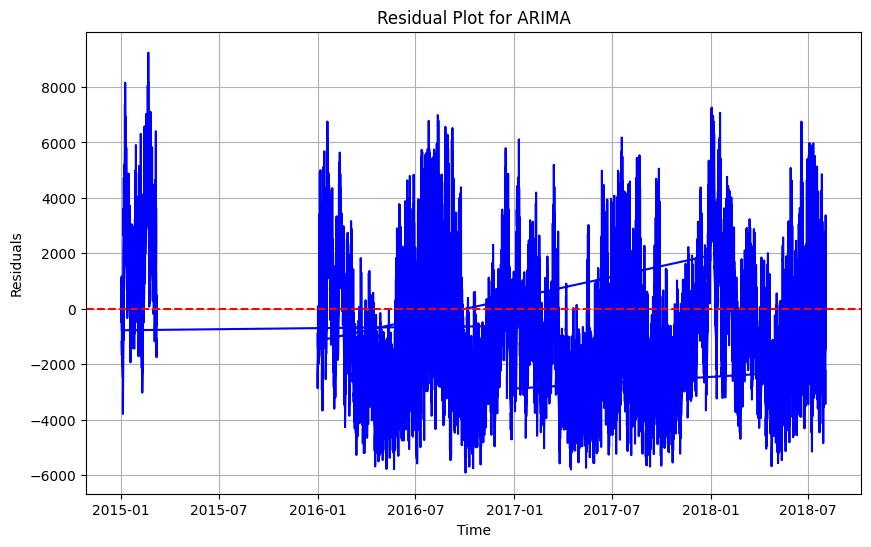

In [6]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataframe 'df' that contains the data
df = pd.read_csv('data/AEP_hourly.csv')
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.set_index('Datetime', inplace=True)

# Assuming 'df' is your complete dataset with training and testing parts separated
# Split data into training and testing sets
train_size = int(len(df) * 0.8)  # 80% train, 20% test
train_data, test_data = df.iloc[:train_size], df.iloc[train_size:]

# Load the SARIMA model
with open('arima_model.pkl', 'rb') as f:
    sarima_model = pickle.load(f)

# Train the SARIMA model on the training data (if not already trained)
# model.fit(train_data)

# Generate forecasts with the loaded SARIMA model
forecast_next_steps = len(test_data)  # Forecast for the entire test set
forecast_next_values = sarima_model.forecast(steps=forecast_next_steps)

# Align timestamps and calculate residuals
forecast_next_values.index = test_data.index  # Align the timestamps
residuals = test_data['AEP_MW'] - forecast_next_values  # Calculate residuals

# Plot residuals
plt.figure(figsize=(10, 6))
plt.plot(residuals.index, residuals, color='blue')
plt.axhline(y=0, color='red', linestyle='--')  # Add a horizontal line at y=0 for reference
plt.title('Residual Plot for ARIMA')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()


## SARIMA

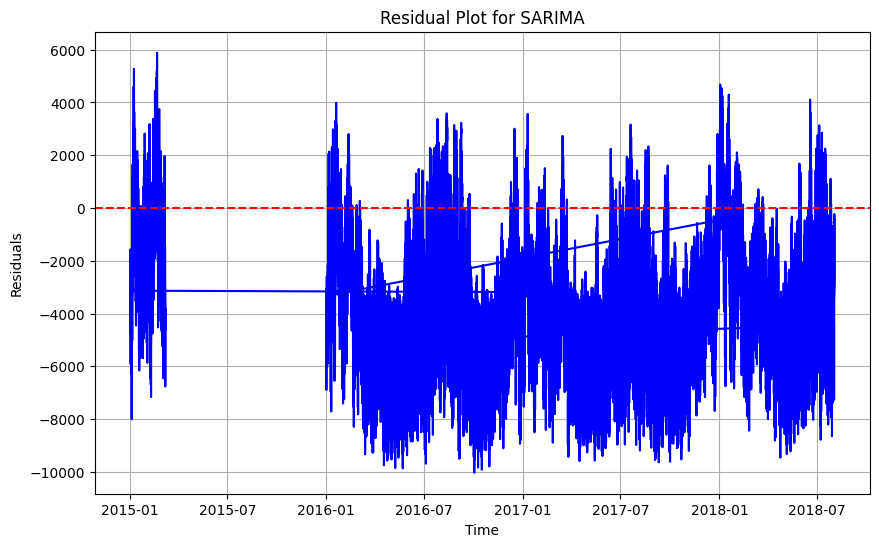

In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataframe 'df' that contains the data
df = pd.read_csv('data/AEP_hourly.csv')
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.set_index('Datetime', inplace=True)

# Assuming 'df' is your complete dataset with training and testing parts separated
# Split data into training and testing sets
train_size = int(len(df) * 0.8)  # 80% train, 20% test
train_data, test_data = df.iloc[:train_size], df.iloc[train_size:]

# Load the SARIMA model
with open('sarima_model.pkl', 'rb') as f:
    sarima_model = pickle.load(f)

# Train the SARIMA model on the training data (if not already trained)
# model.fit(train_data)

# Generate forecasts with the loaded SARIMA model
forecast_next_steps = len(test_data)  # Forecast for the entire test set
forecast_next_values = sarima_model.forecast(steps=forecast_next_steps)

# Align timestamps and calculate residuals
forecast_next_values.index = test_data.index  # Align the timestamps
residuals = test_data['AEP_MW'] - forecast_next_values  # Calculate residuals

# Plot residuals
plt.figure(figsize=(10, 6))
plt.plot(residuals.index, residuals, color='blue')
plt.axhline(y=0, color='red', linestyle='--')  # Add a horizontal line at y=0 for reference
plt.title('Residual Plot for SARIMA')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()


# ETS

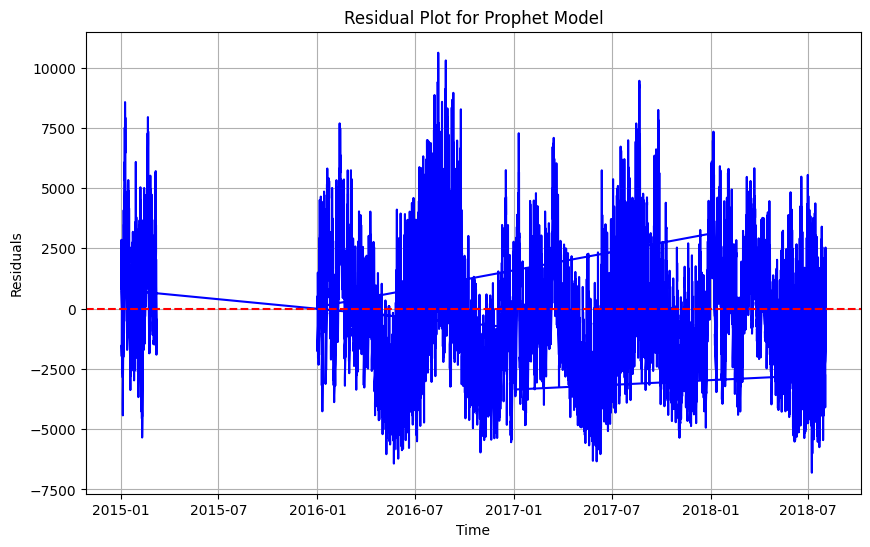

In [12]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataframe 'df' that contains the data
df = pd.read_csv('data/AEP_hourly.csv')
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.set_index('Datetime', inplace=True)

# Assuming 'df' is your complete dataset with training and testing parts separated
# Split data into training and testing sets
train_size = int(len(df) * 0.8)  # 80% train, 20% test
train_data, test_data = df.iloc[:train_size], df.iloc[train_size:]

# Load the Prophet model
with open('prophet_model.pkl', 'rb') as f:
    model, forecast = pickle.load(f)

# Prepare the test data with necessary columns
test_data_prophet = test_data.reset_index().rename(columns={'Datetime': 'ds', 'AEP_MW': 'y'})

# Get forecast for the entire test set
forecast_df = model.predict(test_data_prophet)
forecast_next_values = forecast_df['yhat']

# Align timestamps and calculate residuals
forecast_next_values.index = test_data.index  # Align the timestamps
residuals = test_data['AEP_MW'] - forecast_next_values

# Plot residuals
plt.figure(figsize=(10, 6))
plt.plot(residuals.index, residuals, color='blue')
plt.axhline(y=0, color='red', linestyle='--')  # Add a horizontal line at y=0 for reference
plt.title('Residual Plot for Prophet Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()


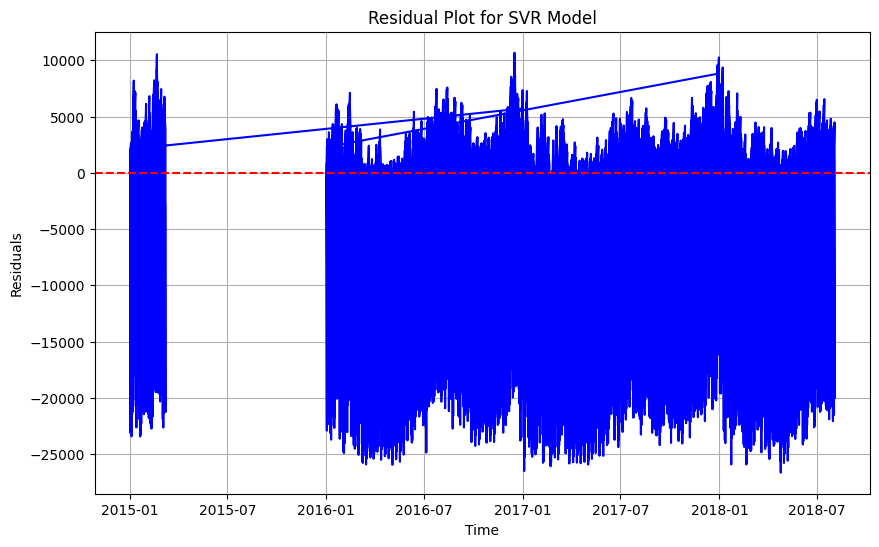

In [15]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the dataframe 'df' that contains the data
df = pd.read_csv('data/AEP_hourly.csv')
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.set_index('Datetime', inplace=True)

# Extract features from datetime index
df['DayOfWeek'] = df.index.dayofweek
df['Month'] = df.index.month
df['DayOfMonth'] = df.index.day
df['Hour'] = df.index.hour

# Assuming 'df' is your complete dataset with training and testing parts separated
# Split data into training and testing sets
train_size = int(len(df) * 0.8)  # 80% train, 20% test
train_data, test_data = df.iloc[:train_size], df.iloc[train_size:]

# Load the SVR model
with open('svr_model.pkl', 'rb') as f:
    svr_model = pickle.load(f)

# Prepare the test data
X_test = test_data[['DayOfWeek', 'Month', 'DayOfMonth', 'Hour']].values  # Features for SVR
y_true = test_data['AEP_MW'].values  # Actual values

# Generate predictions using the SVR model
y_pred = svr_model.predict(X_test)

# Calculate residuals
residuals = y_true - y_pred

# Plot residuals
plt.figure(figsize=(10, 6))
plt.plot(test_data.index, residuals, color='blue')
plt.axhline(y=0, color='red', linestyle='--')  # Add a horizontal line at y=0 for reference
plt.title('Residual Plot for SVR Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()
